In [50]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
train_data = pd.read_csv("twitter_training.csv", header=None)
valid_data = pd.read_csv("twitter_validation.csv", header=None)


In [28]:
column_names = ["Tweet ID", "entity", "sentiment", "Tweet content"]
train_data.columns = column_names
valid_data.columns = column_names

In [40]:
train_data['Tweet content'] = train_data['Tweet content'].fillna("")
print(train_data['Tweet content'].isnull().sum()) 

0


# Preprocessing Code

In [32]:
# Downloading required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [34]:
def preprocess_text(text):
    # Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+|@\S+", "", text)
    # Tokenize text
    words = word_tokenize(text.lower())
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return " ".join(words)

In [41]:
# Apply preprocessing to the 'Tweet content' column
train_data['cleaned_tweet'] = train_data['Tweet content'].apply(preprocess_text)
valid_data['cleaned_tweet'] = valid_data['Tweet content'].apply(preprocess_text)

In [42]:
print(train_data[['Tweet content', 'cleaned_tweet']].head())

                                       Tweet content  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                    cleaned_tweet  
0    im getting borderland murder  
1              coming border kill  
2      im getting borderland kill  
3     im coming borderland murder  
4  im getting borderland 2 murder  


# Sentiment Extraction

In [44]:
analyzer = SentimentIntensityAnalyzer()
def extract_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound']  # Compound score summarizes overall sentiment

In [45]:
# Apply sentiment analysis
train_data['sentiment_score'] = train_data['cleaned_tweet'].apply(extract_sentiment)
valid_data['sentiment_score'] = valid_data['cleaned_tweet'].apply(extract_sentiment)

In [46]:
print(train_data[['cleaned_tweet', 'sentiment_score']].head())

                    cleaned_tweet  sentiment_score
0    im getting borderland murder          -0.6908
1              coming border kill          -0.6908
2      im getting borderland kill          -0.6908
3     im coming borderland murder          -0.6908
4  im getting borderland 2 murder          -0.6908


# Visualization

### 1. Word Clouds:

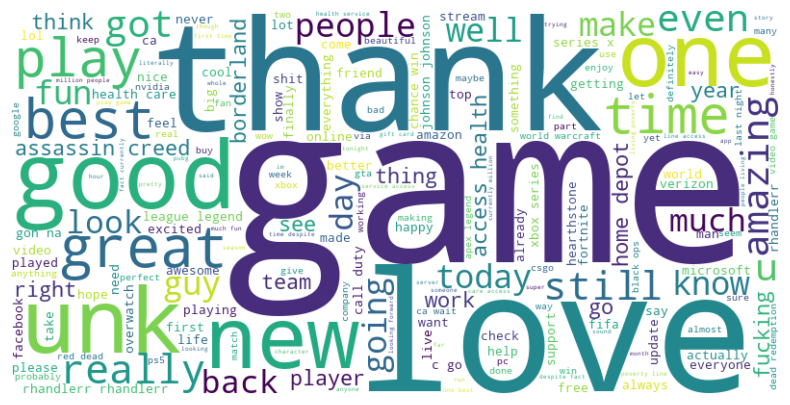

In [49]:
# Generating a word cloud for positive tweets
positive_tweets = " ".join(train_data[train_data['sentiment_score'] > 0.05]['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 2. Sentiment Distribution:

C:\Users\jayes\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


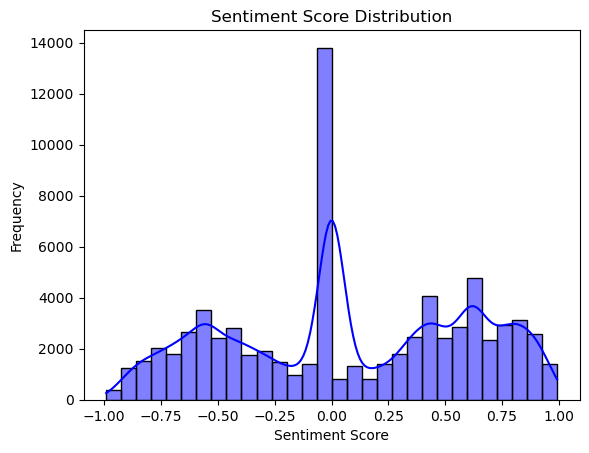

In [51]:
sns.histplot(train_data['sentiment_score'], kde=True, bins=30, color="blue")
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

# Preprocess the Validation Data

In [58]:
# Fill missing values and preprocess text in the validation set
valid_data['Tweet content'] = valid_data['Tweet content'].fillna("")
valid_data['cleaned_tweet'] = valid_data['Tweet content'].apply(preprocess_text)

##  Sentiment Analysis

In [59]:
# Apply sentiment analysis to the cleaned tweet content in the validation dataset
valid_data['sentiment_score'] = valid_data['cleaned_tweet'].apply(extract_sentiment)

#  Visualizing (Validation Data)

### 1. Plot Sentiment Distribution:

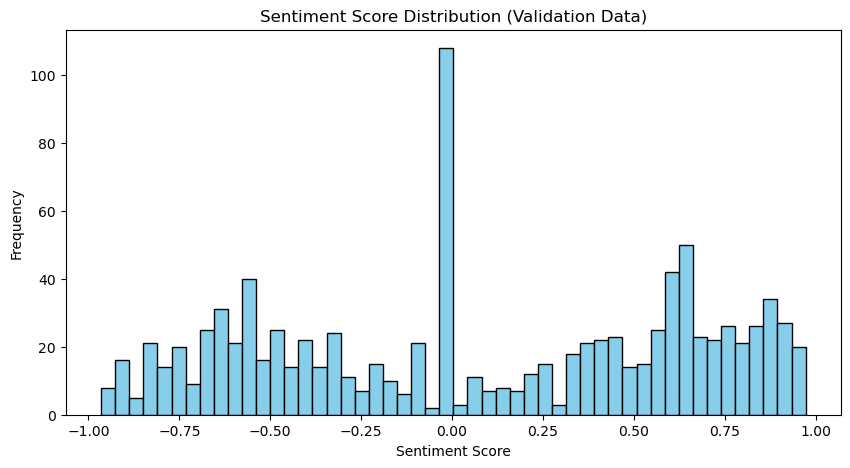

In [63]:
# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 5))
plt.hist(valid_data['sentiment_score'], bins=50, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution (Validation Data)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### 2. Sentiment Score

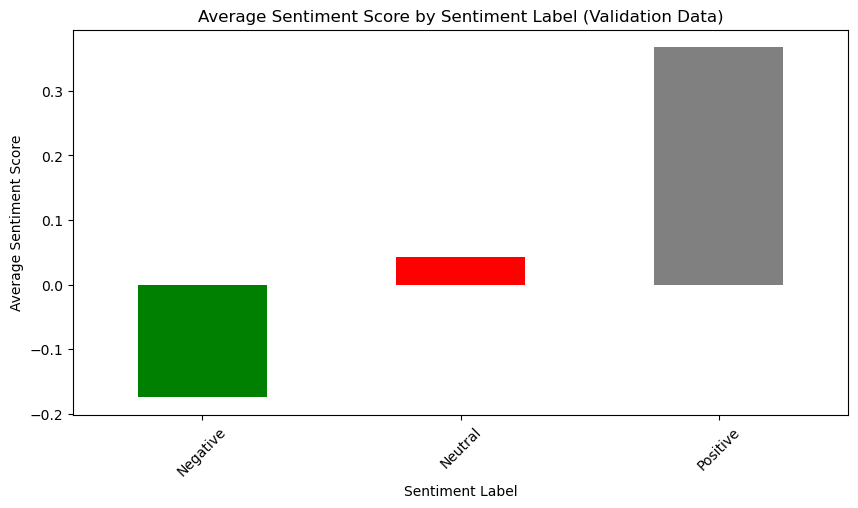

In [64]:
# Map sentiment labels to sentiment scores
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
valid_data['sentiment_label'] = valid_data['sentiment'].map(sentiment_map)

plt.figure(figsize=(10, 5))
valid_data.groupby('sentiment_label')['sentiment_score'].mean().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Average Sentiment Score by Sentiment Label (Validation Data)')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Sentiment Score')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'], rotation=45)
plt.show()

# Compare with Training Data Sentiment Score

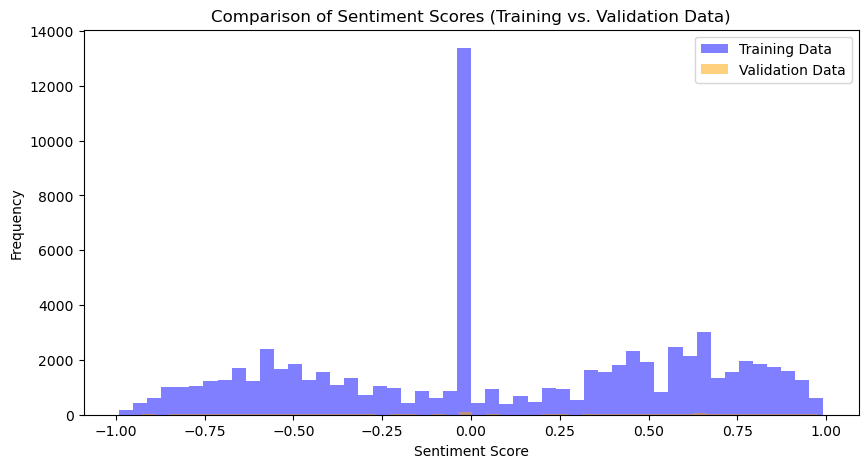

In [65]:
# Plot sentiment score comparison between training and validation data
plt.figure(figsize=(10, 5))
plt.hist(train_data['sentiment_score'], bins=50, alpha=0.5, label='Training Data', color='blue')
plt.hist(valid_data['sentiment_score'], bins=50, alpha=0.5, label='Validation Data', color='orange')
plt.title('Comparison of Sentiment Scores (Training vs. Validation Data)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [68]:
# Export the data with sentiment scores to a CSV file
train_data.to_csv('train_data_with_sentiment.csv', index=False)
valid_data.to_csv('valid_data_with_sentiment.csv', index=False)